## Nikita Baramiya, MSU, Faculty of Economics

In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

In [2]:
X_train, y_train = pd.read_csv('X_train.csv', header=0), pd.read_csv('y_train.csv', header=0)
X_test, y_test_samp = pd.read_csv('X_test.csv', header=0), pd.read_csv('y_test_sample.csv', header=0)
X_train.shape, y_train.shape, X_test.shape, y_test_samp.shape

((105109, 10), (105109, 1), (38876, 11), (38876, 2))

In [3]:
X_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0


# EDA + Feature engineering

#### Features in files X_train and X_test:
- age — возраст заемщика

- family_members — количество членов в семье заемщика

- credit_card_utilization — отношение баланса на счету к лимиту по кредиту

- overdue_30_59_days — число предыдущих просрочек выплат по кредиту от 30 до 59 дней

- overdue_60_89_days — число предыдущих просрочек выплат по кредиту от 60 до 89 дней

- overdue__more_than_90_days — число предыдущих просрочек выплат по кредиту более 90 дней

- debt_to_income — Debt-to-income Ratio

- monthly_income — месячный доход заемщика

- credits_loans — текущее число займов и кредитных линий

- mortgage_loans — текущее количество ипотечных займов

- target — была ли просрочки выплат по кредиту более 90 дней - имеется только в обучающей выборке

Let's look at summary statistics of train and test datas.

In [4]:
X_train.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,105109.000000,105109.000000,105109.000000,105109.000000,8.411600e+04,105109.000000,105109.000000,105109.000000,105109.000000,102304.000000
mean,5.825173,53.321067,0.426643,354.188156,6.649725e+03,8.956255,0.269967,1.018514,0.244356,0.757096
std,251.021431,14.811007,4.251225,1827.184165,1.106504e+04,5.182715,4.227366,1.136228,4.214018,1.116525
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029592,42.000000,0.000000,0.173670,3.343201e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153792,53.000000,0.000000,0.365047,5.361778e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.554374,64.000000,0.000000,0.880882,8.207866e+03,12.000000,0.000000,2.000000,0.000000,1.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [5]:
X_test.describe()

,index,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,38876.000000,38876.000000,38876.000000,38876.000000,38876.000000,3.133100e+04,38876.000000,38876.000000,38876.000000,38876.000000,37921.000000
mean,71772.980116,7.143140,53.236238,0.406986,351.627896,6.726128e+03,8.946599,0.252598,1.017466,0.229808,0.759131
std,41436.065456,259.023345,14.772393,4.023815,2545.254355,2.116051e+04,5.153647,3.999838,1.113531,3.985055,1.112832
min,5.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35939.250000,0.029097,42.000000,0.000000,0.170806,3.349846e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,71714.000000,0.152136,53.000000,0.000000,0.361875,5.339619e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,107495.250000,0.558911,64.000000,0.000000,0.843592,8.264207e+03,12.000000,0.000000,2.000000,0.000000,1.000000
max,143975.000000,32131.063581,110.000000,98.000000,349464.845051,3.117341e+06,56.000000,98.000000,23.000000,98.000000,9.000000


and check for missing values:

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105109 entries, 0 to 105108
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   credit_card_utilization     105109 non-null  float64
 1   age                         105109 non-null  int64  
 2   overdue_30_59_days          105109 non-null  int64  
 3   debt_to_income              105109 non-null  float64
 4   monthly_income              84116 non-null   float64
 5   credits_loans               105109 non-null  int64  
 6   overdue__more_than_90_days  105109 non-null  int64  
 7   mortgage_loans              105109 non-null  int64  
 8   overdue_60_89_days          105109 non-null  int64  
 9   family_members              102304 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 8.0 MB


In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38876 entries, 0 to 38875
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       38876 non-null  int64  
 1   credit_card_utilization     38876 non-null  float64
 2   age                         38876 non-null  int64  
 3   overdue_30_59_days          38876 non-null  int64  
 4   debt_to_income              38876 non-null  float64
 5   monthly_income              31331 non-null  float64
 6   credits_loans               38876 non-null  int64  
 7   overdue__more_than_90_days  38876 non-null  int64  
 8   mortgage_loans              38876 non-null  int64  
 9   overdue_60_89_days          38876 non-null  int64  
 10  family_members              37921 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 3.3 MB


We see missing values in monthly_income and family_members, further we need to deal with it. Look at the target variable:

In [8]:
y_train.target.value_counts()

0    98078
1     7031
Name: target, dtype: int64

We see that classes are imbalanced and we should keep it in mind.

Let's concatenate train explanatory and target variables: it may be convenient for future processing.

In [9]:
Xy_train = pd.concat([X_train, y_train], axis=1)

## Age

Look at the rarest values of "age" feature in train and test data:

In [10]:
Xy_train.age.value_counts()[::-1].head(15)

0       1
111     1
107     2
103     2
102     2
101     3
100     3
99      8
98     11
97     19
96     28
21     36
95     40
94     47
93     87
Name: age, dtype: int64

In [11]:
X_test.age.value_counts()[::-1].head(15)

103     1
110     1
102     1
105     2
99      2
100     3
98      3
97      9
94     11
96     13
95     14
21     16
93     29
92     45
22     51
Name: age, dtype: int64

First of all, drop observation with age = 0 (it's exactly the outlier), than create categorical variable that simplifies the work of both trees (fewer number of thresholds) and linear models (easier to make relevant one-hot-encoding).

In [12]:
Xy_train = Xy_train[Xy_train.age > 0]

In [13]:
for data in [Xy_train, X_test]:
    data.loc[data.age <= 24, 'age_cat'] = '18_24'

    for current_age in [35, 45, 55, 65]:
        data.loc[(data.age.between(current_age-10, current_age-1)), 
                   'age_cat'] = f'{current_age-10}_{current_age-1}'

    data.loc[(data.age >= 65) & (data.age < 85), 'age_cat'] = '65_84'
    data.loc[(data.age >= 85), 'age_cat'] = '85_'

Next cell checks tha balance of categories (I will repeat this with other features too).

In [14]:
Xy_train.age_cat.value_counts(normalize=True) - X_test.age_cat.value_counts(normalize=True)

45_54    0.001266
55_64   -0.002032
65_84    0.000329
35_44    0.000114
25_34   -0.001240
85_      0.001418
18_24    0.000144
Name: age_cat, dtype: float64

## Family members

Let's look on values of "family_members" feature:

In [15]:
Xy_train.family_members.value_counts()

0.0     60844
1.0     18525
2.0     13607
3.0      6595
4.0      2022
5.0       538
6.0       111
7.0        33
8.0        19
10.0        5
9.0         2
13.0        1
20.0        1
Name: family_members, dtype: int64

In [16]:
X_test.family_members.value_counts()

0.0    22536
1.0     6780
2.0     5124
3.0     2514
4.0      719
5.0      182
6.0       41
7.0       18
8.0        4
9.0        3
Name: family_members, dtype: int64

In [17]:
Xy_train[Xy_train.family_members > 9]

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target,age_cat
14852,0.019166,48,1,0.374951,7905.649003,8,0,1,0,10.0,0,45_54
16514,0.000000,44,0,0.045493,10197.229559,5,0,0,0,10.0,0,35_44
21733,0.133545,44,1,3321.364632,0.000000,9,0,1,0,10.0,0,35_44
44605,1.032099,54,1,0.273139,3626.974798,3,1,1,0,13.0,0,45_54
71292,0.220114,41,1,0.487007,6473.042881,12,2,1,0,20.0,0,35_44
89080,0.312901,40,0,0.023831,4945.736524,7,0,0,0,10.0,0,35_44
104455,0.070697,60,0,0.110718,7474.461388,10,0,0,0,10.0,0,55_64


We see that observations above can be painlessly dropped (target = 0). Drop them and create categorical variable as well (for nans separate category).

In [18]:
Xy_train.drop(index=Xy_train[Xy_train.family_members > 9].index, inplace=True)

In [19]:
for data in [Xy_train, X_test]:
    data.loc[data.family_members == 0, 'family'] = 'not'
    data.loc[data.family_members == 1, 'family'] = 'one'
    data.loc[data.family_members == 2, 'family'] = 'two'
    data.loc[data.family_members == 3, 'family'] = 'three'
    data.loc[data.family_members >= 4, 'family'] = 'four_and_more'
    data.loc[data.family_members.isna(), 'family'] = 'unknown'

In [20]:
Xy_train.family.value_counts(normalize=True) - X_test.family.value_counts(normalize=True)

four_and_more    0.001053
not             -0.000779
one              0.001858
three           -0.001918
two             -0.002338
unknown          0.002123
Name: family, dtype: float64

## Credit utilization rate

In [21]:
(Xy_train.credit_card_utilization > 1).sum(), (X_test.credit_card_utilization > 1).sum()

(6959, 2616)

According to information from the Internet, we divide values into several groups. It's strange for ratio to be more than 1, for such ones make extra category.

In [22]:
for data in [Xy_train, X_test]:
    data.loc[data.credit_card_utilization > 1, 'cur'] = 'strange'
    data.loc[data.credit_card_utilization == 0, 'cur'] = 'too_good'

    data.loc[(data.credit_card_utilization > 0) & (data.credit_card_utilization <= 0.3), 'cur'] = 'good'
    data.loc[(data.credit_card_utilization > 0.3) & (data.credit_card_utilization <= 0.7), 'cur'] = 'ok'
    data.loc[(data.credit_card_utilization > 0.7) & (data.credit_card_utilization <= 1), 'cur'] = 'bad'

In [23]:
Xy_train.cur.value_counts(normalize=True) - X_test.cur.value_counts(normalize=True)

good        0.000152
ok          0.002866
bad        -0.001007
too_good   -0.000932
strange    -0.001078
Name: cur, dtype: float64

## Overdue payments

For "overdue payments" columns we repeat similar procedures as above.

In [24]:
Xy_train.overdue_30_59_days.value_counts()

0     88258
1     11258
2      3233
3      1222
4       525
5       241
98      189
6       102
7        37
8        17
9         8
96        5
10        4
12        1
11        1
Name: overdue_30_59_days, dtype: int64

In [25]:
X_test.overdue_30_59_days.unique()

array([ 0,  1, 98,  2,  5,  4,  3,  7, 12, 13,  9,  6,  8])

In [26]:
Xy_train.overdue_60_89_days.value_counts()

0     99814
1      4020
2       744
3       216
98      189
4        73
5        22
6         9
7         6
96        5
11        1
9         1
8         1
Name: overdue_60_89_days, dtype: int64

In [27]:
X_test.overdue_60_89_days.unique()

array([ 0,  1, 98,  2,  4,  3,  7,  5,  6,  8])

In [28]:
Xy_train.overdue__more_than_90_days.value_counts()

0     99316
1      3621
2      1085
3       461
4       209
98      189
5        99
6        48
7        24
8        18
9        13
96        5
13        4
10        4
11        3
12        2
Name: overdue__more_than_90_days, dtype: int64

In [29]:
X_test.overdue__more_than_90_days.unique()

array([ 0,  1, 98,  2,  3,  5,  6,  4, 11,  9,  7, 14,  8, 10, 15])

In [30]:
Xy_train = Xy_train.loc[(Xy_train.overdue_30_59_days != 96) & (Xy_train.overdue_60_89_days != 96)]

In [31]:
columns_new = ['overdue_30_59', 'overdue_60_89', 'overdue_90_higher']
for i, col in enumerate(['overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days']):
    for data in [Xy_train, X_test]:
        data.loc[data[col] == 98, columns_new[i]] = 'unknown'
        data.loc[data[col] == 0, columns_new[i]] = '0'
        data.loc[data[col] == 1, columns_new[i]] = '1'
        data.loc[data[col] == 2, columns_new[i]] = '2'
        data.loc[data[col].between(3, 25), columns_new[i]] = '3+'

In [32]:
Xy_train.overdue_30_59.value_counts(normalize=True) - X_test.overdue_30_59.value_counts(normalize=True)

0         -0.000039
1         -0.000066
2          0.000152
3+        -0.000199
unknown    0.000152
Name: overdue_30_59, dtype: float64

In [33]:
Xy_train.overdue_60_89.value_counts(normalize=True) - X_test.overdue_60_89.value_counts(normalize=True)

0          0.002190
1         -0.000514
2         -0.001512
3+        -0.000316
unknown    0.000152
Name: overdue_60_89, dtype: float64

In [34]:
Xy_train.overdue_90_higher.value_counts(normalize=True) - X_test.overdue_90_higher.value_counts(normalize=True)

0          0.001258
1         -0.001609
2          0.000215
3+        -0.000016
unknown    0.000152
Name: overdue_90_higher, dtype: float64

## Debt to income ratio

Create new column from debt-to-income raio and monthly income (maybe it will be useful) and fill nans with -1.

In [35]:
for data in [Xy_train, X_test]:
    data['monthly_debt'] = data.debt_to_income * data.monthly_income
    data.loc[data.monthly_debt.isna(), 'monthly_debt'] = -1
    data.loc[data.monthly_income.isna(), 'monthly_income'] = -1

In [36]:
Xy_train.debt_to_income[Xy_train.debt_to_income > 1].value_counts()

1045.399023    1
568.647642     1
2424.910813    1
1.413065       1
6140.327473    1
              ..
931.515391     1
216.866142     1
1492.346241    1
908.307626     1
526.881135     1
Name: debt_to_income, Length: 24953, dtype: int64

Again, strange values will have their own category.

In [37]:
for data in [Xy_train, X_test]:
    data.loc[data.debt_to_income > 1, 'debt_to_income_rate'] = 'strange'
    data.loc[data.debt_to_income == 0, 'debt_to_income_rate'] = 'too_good'
    
    data.loc[(data.debt_to_income > 0) & (data.debt_to_income <= 0.35), 'debt_to_income_rate'] = 'good'
    data.loc[(data.debt_to_income > 0.35) & (data.debt_to_income <= 0.49), 'debt_to_income_rate'] = 'not_ok'
    data.loc[(data.debt_to_income > 0.49) & (data.debt_to_income <= 1), 'debt_to_income_rate'] = 'bad'

In [38]:
Xy_train.debt_to_income_rate.value_counts(normalize=True) - X_test.debt_to_income_rate.value_counts(normalize=True)

good       -0.003984
strange     0.006208
bad        -0.000725
not_ok     -0.001526
too_good    0.000027
Name: debt_to_income_rate, dtype: float64

## Credit and mortgage loans

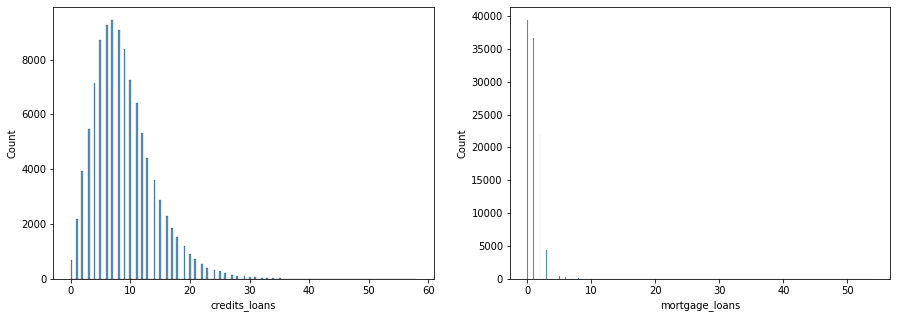

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=Xy_train, x='credits_loans', ax=ax[0])
sns.histplot(data=Xy_train, x='mortgage_loans', ax=ax[1])
plt.show()

The distribution of credits_loans looks quite well, maybe we can try to use it in the model without changes, but we also make categorical features for credits_loans and mortgage_loans.

In [40]:
Xy_train.credits_loans.unique()

array([ 9,  5, 12, 15,  0,  8,  4, 19, 21,  6,  7, 13,  3, 20, 17, 22,  2,
       10, 11, 14, 16,  1, 32, 18, 25, 27, 36, 24, 28, 23, 34, 49, 30, 26,
       29, 44, 42, 33, 45, 31, 58, 39, 35, 37, 46, 55, 40, 54, 38, 53, 43,
       48, 50, 41, 56, 52, 57, 51, 47])

In [41]:
Xy_train.credits_loans.value_counts()

7     9439
6     9259
8     9058
5     8701
9     8370
10    7250
4     7153
11    6400
3     5457
12    5337
13    4414
2     3946
14    3590
15    2879
16    2280
1     2201
17    1863
18    1510
19    1187
20     907
21     722
0      676
22     551
23     413
24     334
25     270
26     217
27     145
28     114
29      96
30      67
31      55
32      46
33      42
34      32
35      20
36      13
37      10
39       8
42       7
44       7
46       6
40       5
41       5
38       5
49       4
54       3
48       3
43       3
45       3
52       2
53       2
58       2
50       2
51       1
47       1
55       1
56       1
57       1
Name: credits_loans, dtype: int64

In [42]:
X_test.credits_loans.unique()

array([ 9,  6, 14,  8,  3, 12, 10, 13,  7, 15, 16, 29,  5,  2, 17,  4, 11,
        1, 25, 18, 21,  0, 22, 19, 24, 20, 31, 28, 26, 27, 23, 37, 34, 33,
       30, 39, 35, 36, 32, 41, 40, 54, 44, 38, 49, 52, 46, 56, 50])

In [43]:
for data in [Xy_train, X_test]:
    data.loc[data.credits_loans <= 2, 'credits_loans_cat'] = '0-2'
    data.loc[data.credits_loans.between(3, 5), 'credits_loans_cat'] = '3-5'
    data.loc[data.credits_loans.between(6, 7), 'credits_loans_cat'] = '6-7'
    data.loc[data.credits_loans.between(8, 9), 'credits_loans_cat'] = '8-9'
    data.loc[data.credits_loans.between(10, 11), 'credits_loans_cat'] = '10-11'
    data.loc[data.credits_loans.between(12, 14), 'credits_loans_cat'] = '12-14'
    data.loc[data.credits_loans.between(15, 20), 'credits_loans_cat'] = '15-19'
    data.loc[data.credits_loans >= 21, 'credits_loans_cat'] = '20+'

In [44]:
Xy_train.credits_loans_cat.value_counts(normalize=True) - X_test.credits_loans_cat.value_counts(normalize=True)

3-5      0.000544
6-7     -0.000140
8-9      0.000174
10-11   -0.000173
12-14    0.000333
15-19   -0.001604
0-2      0.000229
20+      0.000636
Name: credits_loans_cat, dtype: float64

In [45]:
Xy_train.mortgage_loans.value_counts()

0     39366
1     36693
2     22040
3      4432
4      1514
5       501
6       228
7       116
8        60
9        56
10       23
11       17
12       11
13       11
14        5
15        4
17        4
25        3
16        2
19        2
20        2
32        1
18        1
21        1
26        1
29        1
54        1
Name: mortgage_loans, dtype: int64

In [46]:
for data in [Xy_train, X_test]:
    data.loc[data.mortgage_loans == 0, 'mortgage_loans_cat'] = '0'
    data.loc[data.mortgage_loans == 1, 'mortgage_loans_cat'] = '1'
    data.loc[data.mortgage_loans == 2, 'mortgage_loans_cat'] = '2'
    data.loc[data.mortgage_loans >= 3, 'mortgage_loans_cat'] = '3+'

In [47]:
Xy_train.mortgage_loans_cat.value_counts()

0     39366
1     36693
2     22040
3+     6997
Name: mortgage_loans_cat, dtype: int64

In [48]:
Xy_train.mortgage_loans_cat.value_counts(normalize=True) - X_test.mortgage_loans_cat.value_counts(normalize=True)

0    -0.000132
1     0.000928
2    -0.001111
3+    0.000315
Name: mortgage_loans_cat, dtype: float64

# Train-Valid split

In [49]:
X_train_valid, y_train_valid = Xy_train.drop(columns=['family_members', 'target']), Xy_train['target']
X_test = X_test.drop(columns=['index', 'family_members'])

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, 
                                                      stratify=y_train_valid, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((84076, 19), (21020, 19), (84076,), (21020,))

In [51]:
X_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,age_cat,family,cur,overdue_30_59,overdue_60_89,overdue_90_higher,monthly_debt,debt_to_income_rate,credits_loans_cat,mortgage_loans_cat
32560,1.060891,69,0,0.412589,1390.594179,3,0,2,1,65_84,one,strange,0,1,0,573.743612,not_ok,3-5,2
47607,0.018324,52,0,0.283190,10541.362802,9,0,1,0,45_54,not,good,0,0,0,2985.211813,good,8-9,1
11586,0.050553,32,0,0.560016,3225.050340,6,0,2,0,25_34,not,good,0,0,0,1806.080233,bad,6-7,2
61137,0.502450,41,1,0.465524,4037.595174,10,0,1,0,35_44,two,ok,1,0,0,1879.595977,not_ok,10-11,1
12178,0.105071,66,0,0.052607,12029.920330,8,0,1,0,65_84,not,good,0,0,0,632.861205,good,8-9,1


# Models

## Gradient boosting (Yandex catboost)

Firstly, try gradient boosting, I use yandex implementation as it has inbuilt preprocessing for categorical features, using powerful "target encoding" technique (I am lazy to do it by myself).

In [52]:
clf1 = CatBoostClassifier(cat_features=['age_cat', 'family', 'cur', 'overdue_30_59', 'overdue_60_89',
                                        'overdue_90_higher', 'debt_to_income_rate', 'credits_loans_cat',
                                        'mortgage_loans_cat'], eval_metric='AUC', random_state=42,
                         allow_writing_files=False, verbose=200, eta=0.1, n_estimators=350)
clf1.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	test: 0.8051314	best: 0.8051314 (0)	total: 754ms	remaining: 4m 23s
200:	test: 0.8626636	best: 0.8627884 (182)	total: 27.7s	remaining: 20.5s
349:	test: 0.8629369	best: 0.8630843 (307)	total: 46.3s	remaining: 0us

bestTest = 0.8630843379
bestIteration = 307

Shrink model to first 308 iterations.


In [53]:
roc_auc_score(y_score=clf1.predict_proba(X_train_valid)[:, 1], y_true=y_train_valid)

0.8740371340762312

In [54]:
# y_test_samp['target'] = clf1.predict_proba(X_test)[:, 1]
# y_test_samp.to_csv('try_6.csv', header=True, index=False)

This method gives me the first place on the public leaderboard and the second on the private one.

## Logistic Regression

Also I have tried more interpreted linear model for prediction.

In [55]:
cat_cols = ['age_cat', 'family', 'cur', 'overdue_30_59', 'overdue_60_89', 'overdue_90_higher', 
            'debt_to_income_rate', 'credits_loans_cat', 'mortgage_loans_cat']

In [56]:
ohe = OneHotEncoder(drop='first')
X_train_valid_ohe = ohe.fit_transform(X_train_valid.loc[:, cat_cols])
X_test_ohe = ohe.transform(X_test.loc[:, cat_cols])

In [57]:
clf2 = LogisticRegressionCV(Cs=10).fit(X_train_valid_ohe, y_train_valid)

In [58]:
roc_auc_score(y_score=clf2.predict_proba(X_train_valid_ohe)[:, 1], y_true=y_train_valid)

0.8577406291553656

In [59]:
# y_test_samp['target'] = clf2.predict_proba(X_test_ohe)[:, 1]
# y_test_samp.to_csv('try_6.csv', header=True, index=False)

It gives slightly worse results but can be useful (see discusion further).

# Ideas for improving score

It's not so interesting to implement these ideas after the competition end, but I decided it's important to mention them:

- hyperparameter tuning: we have a wide field for tuning catboost parameters and also we can try to tune more subtly C parameter of logistic regression, for example, with hyperopt.

- stacking: when we already choose the best parameters for models above, we can unite them and it's very likely to be a great idea due to their diversity. Also we can add k nearest neighbors, random forest and neural net models to them to make stacking technique more stronger.

- advanced feature engineering: I could miss some details, maybe, some interactions of features, which can add useful information for prediction, and after adding them we can tune parameters and stack models again.

# That's all :)